# DESIGN OF EXPERIMENTS

This notebook introduces the codes required to do a 1-way design.

# Overview

A study should address the following:
1. What are the research questions? In this study, we want to understand how the kinetic contants affect oscillations in the Wolf Model.
1. What are the factors and levels? The factors are the kinetic constants. The levels are percentage changes in the values of the contants compared with the baseline.
1. What are the responses? In this study, the responses are the sustained oscillations in the model. These will be calculated using the Fast Fourier Transform (FFT).


This lecture illustrates a workflow for developing codes that run studies to do a one-factor-at-a-time (OFT) experimental design.
The running example is the model of glycolytic oscillations developed in J. Wolf et al., Biochem., 2000.

The function ``runStudy`` encapsulates the full workflow. This consists of:
1. running simulations for the factors and levels to be studied
1. calculating response values from the simulation results
1. constructing a table (dataframe) that reports the responses $y$ by factor level
1. calculating the $\mu$, $\alpha$ for design of experiments

The notebook contains codes for (1)-(3) for the Wolf model.
Responses are the oscillation frequency for glucose.

## Data rules
1. Simulation outputs are dataframes.
   * Names of molecules do not have "[", "]"
   * index is time
1. The names of chemical species do not have "[", "]"
1. Changes in factor values are always in percents.

# Preliminaries

## Imports

In [1]:
# First code cell in a notebook contains all installs
!apt-get install libncurses5
!pip install -q tellurium==2.2.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
from scipy import fftpack
import seaborn as sns
import tellurium as te

## Constants

In [3]:
# Constants
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value

## Helper Functions

In [4]:
TEST_MODEL = """
A -> B; k*A

k = 1
A = 0
"""

In [5]:
def arrToDF(arr):
    """
    Converts a NamedArray to a DataFrame.

    Args:
    ----------
    arr: NamedArray

    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    return pd.DataFrame(arr, columns=columns)

# TESTS
rr = te.loada("A -> B; 1; A=0; B=0; a=2")
arr = rr.simulate()
df = arrToDF(arr)
assert(isinstance(df, pd.DataFrame))
trues = ["[" not in c and "]" not in c for c in df.columns]
assert(all(trues))

In [6]:
def getFactorValueDct(model):
    """
    Finds the name and value of all factors (kinetic constants).

    Arguments
    ----------
    model: str (Antimony model)

    Returns
    -------
    dict (key: str, value: float)
    """
    rr = te.loada(model)
    dct = {}
    for name in rr.model.getGlobalParameterIds():
        try:
            rr[name] = rr[name]
            dct[name] = rr[name]
        except:
            pass
    return dct

# Tests
dct = getFactorValueDct(TEST_MODEL)
assert(isinstance(dct, dict))
assert("k" in dct.keys())
print("OK!")

OK!


# Wolf Model

We begin with an exploration of the Wolf model to understand the effect of kinetic constants (factors) to determine what responses should be reported by an experiment.

## Constants

In [7]:
WOLF_MODEL = """
// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k;
  const J4_kg, J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2;
  const J9_k, J10_k;
end
"""

In [8]:
# Constants used in the analysis of the Wolf model
START = 0
END = 5
NUMPT = 1000  # number of points to simulate
WOLF_RR = te.loada(WOLF_MODEL)
FACTOR_DCT = getFactorValueDct(WOLF_MODEL)
WOLF_FACTORS = list(FACTOR_DCT.keys())
rr = te.loada(WOLF_MODEL)
WOLF_DF = arrToDF(rr.simulate(START, END, NUMPT))
WOLF_DF = WOLF_DF.set_index("time")
WOLF_SPECIES = list(WOLF_DF.columns)
SPECIES = "Glucose"  # Used in tests
FACTOR = "J1_k1"  # Used in tests

## Exploration of the Model

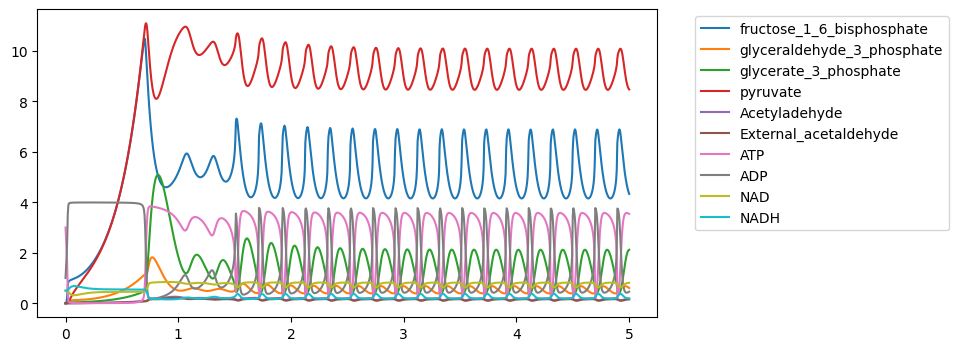

In [9]:
def timePlots(df=WOLF_DF, title="", isPlot=True):
    """
    Plots floating species over time.

    Args
    ----------
    df: DataFrame
        index: time
        columns: species
    title: str
        Title of plot
    isPlot: bool
    """
    fig, ax = plt.subplots(1, figsize=(8, 4))
    arr = df.values
    colnames = df.columns
    p = ax.plot(df.index, arr[:,1:])
    _ = ax.legend(p, colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
    if isPlot:
        plt.show()

# Tests
timePlots(isPlot=False)

# Pandas DataFrame
* A convenient representation of tabular data because it keeps column names and provides an ability to do arithmetic on columns.


## Basics

In [10]:
arr1 = np.array(range(5))
arr2 = arr1**2
df = pd.DataFrame(np.array([arr1, arr2]), index=["x", "xsq"])
df

,0,1,2,3,4
x,0,1,2,3,4
xsq,0,1,4,9,16


In [11]:
df1 = df.T
df1

,x,xsq
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16


In [12]:
df1["x"]

0    0
1    1
2    2
3    3
4    4
Name: x, dtype: int64

## DataFrame for Simulation Output

In [13]:
data_arr = WOLF_RR.simulate()
data_arr
#WOLF_RR.plot()

    time, [Glucose], [fructose_1_6_bisphosphate], [glyceraldehyde_3_phosphate], [glycerate_3_phosphate], [pyruvate], [Acetyladehyde], [External_acetaldehyde],      [ATP],    [ADP],    [NAD],   [NADH]
 [[    0,         0,                           0,                            0,                       0,          0,               0,                       0,          3,        1,      0.5,      0.5],
  [  0.1,   3.20146,                     1.02597,                     0.131118,               0.0384497,   0.617415,      0.00420064,               0.0033757, 0.00697457,  3.99303, 0.329652, 0.670348],
  [  0.2,   6.69339,                     1.37814,                     0.156943,               0.0574787,    1.22902,      0.00944996,              0.00768339, 0.00500414,    3.995, 0.407367, 0.592633],
  [  0.3,   9.40088,                      2.0284,                     0.219926,               0.0876349,    1.97774,       0.0160874,               0.0131216, 0.00543637,  3.99456, 0.440691, 0.5

In [14]:
df = pd.DataFrame(data_arr)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.500000,0.500000
1,0.1,3.201461,1.025973,0.131118,0.038450,0.617415,0.004201,0.003376,0.006975,3.993025,0.329652,0.670348
2,0.2,6.693389,1.378138,0.156943,0.057479,1.229015,0.009450,0.007683,0.005004,3.994996,0.407367,0.592633
3,0.3,9.400883,2.028404,0.219926,0.087635,1.977743,0.016087,0.013122,0.005436,3.994564,0.440691,0.559309
4,0.4,10.904440,3.065856,0.328316,0.133605,3.054269,0.025219,0.020589,0.007144,3.992856,0.449224,0.550776


In [15]:
data_arr.colnames

['time',
 '[Glucose]',
 '[fructose_1_6_bisphosphate]',
 '[glyceraldehyde_3_phosphate]',
 '[glycerate_3_phosphate]',
 '[pyruvate]',
 '[Acetyladehyde]',
 '[External_acetaldehyde]',
 '[ATP]',
 '[ADP]',
 '[NAD]',
 '[NADH]']

In [16]:
df = pd.DataFrame(data_arr)
columns = []
for column in data_arr.colnames:
    if column[0] == "[":
        new_column = column[1:-1]
    else:
        new_column = column
    columns.append(new_column)
df.columns =columns
df = df.set_index("time")
df.head()

,Glucose,fructose_1_6_bisphosphate,glyceraldehyde_3_phosphate,glycerate_3_phosphate,pyruvate,Acetyladehyde,External_acetaldehyde,ATP,ADP,NAD,NADH
time,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.500000,0.500000
0.1,3.201461,1.025973,0.131118,0.038450,0.617415,0.004201,0.003376,0.006975,3.993025,0.329652,0.670348
0.2,6.693389,1.378138,0.156943,0.057479,1.229015,0.009450,0.007683,0.005004,3.994996,0.407367,0.592633
0.3,9.400883,2.028404,0.219926,0.087635,1.977743,0.016087,0.013122,0.005436,3.994564,0.440691,0.559309
0.4,10.904440,3.065856,0.328316,0.133605,3.054269,0.025219,0.020589,0.007144,3.992856,0.449224,0.550776


# Running Simulations With Changes in Values of Factors

The first thing we need to do is to be able to run an experiment when the value of a factor is changed. In our case, a factor is a kinetic constant.

Below is one way to to do simulations that change a value of a factor.

**Goal**: Write a function that runs a simulation with specification of changes in factors: and outputs a dataframe in our standard format.

In [17]:
def simulate(factor=None, value=None, model_ant=WOLF_MODEL):
    """
    Run a simulation changing a single factor.

    Args:
        factor: str
        value: float
        model_ant: Antimony source

    Returns:
        Standard DataFrame (columns are species, index is time)
    """
    rr = te.loada(model_ant)
    if factor is not None:
        rr[factor] = value
    data_arr = rr.simulate()
    # Convert to standard dataframe
    df = pd.DataFrame(data_arr)
    columns = []
    for column in data_arr.colnames:
        if column[0] == "[":
            new_column = column[1:-1]
        else:
            new_column = column
        columns.append(new_column)
    df.columns =columns
    df = df.set_index("time")
    #
    return df

# Test
factor = "J1_k1"
value = 3
df_change = simulate(factor, value, WOLF_MODEL)
assert(isinstance(df, pd.DataFrame))
# Simulate baseline
df_baseline = simulate()
assert(isinstance(df, pd.DataFrame))
# Is df_change different from df_basline?
difference = np.sum(np.sum(df_change - df_baseline)**2)
assert(difference > 1e3)
print("OK!")

OK!


There are some issues with the foregoing function.
1. It does the simulation for only a single factor.
1. We provide it with an *absolute* value of the change. This may be inconvenient if factors (in our case, parameters of the simulation) have different units.

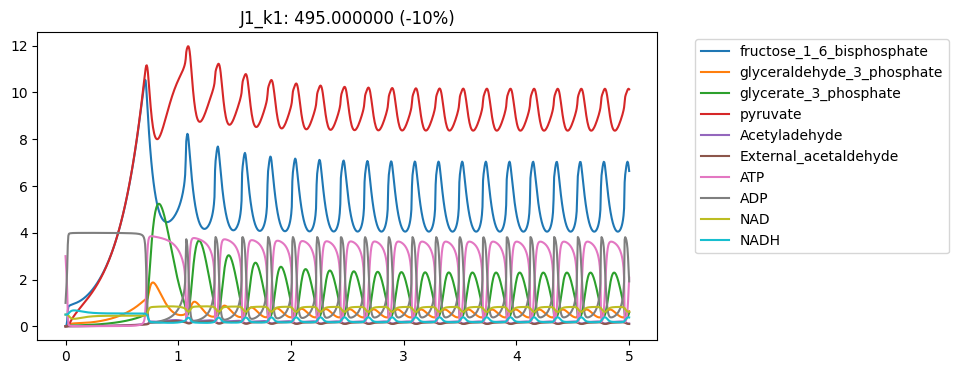

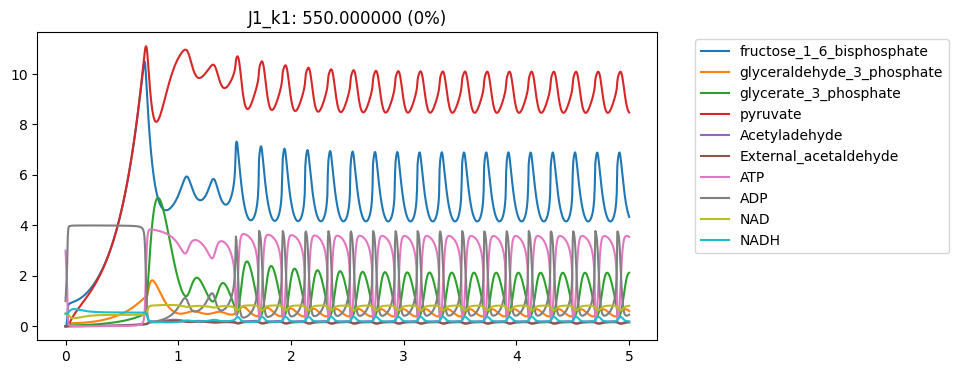

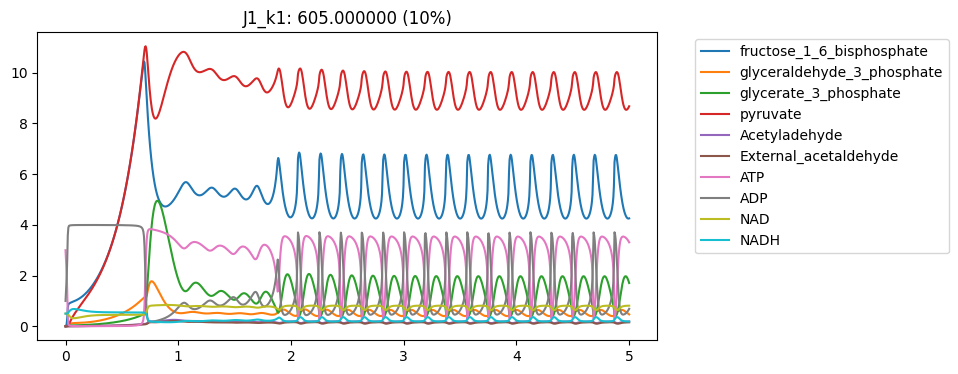

OK!


In [18]:
def runSimulations(factor, percents, model=WOLF_MODEL, isPlot=True):
    """
    Runs experiments and produces plots for the percent changes in the value
    of factors.

    Arguments:
    ----------
    factor: str (a kinetic constant in the model)
    percents: list-float
        list of percent change in values
          (smallest value is -100)
    model: str (Antimony model)

    Returns:
    -------
    dict:
        key: pct
        value: DataFrame
    """
    roadrunner = te.loada(model)
    baseValue = roadrunner[factor]
    if not factor in roadrunner.keys():
        raise ValueError("Unknown factor name: %s" % factor)
    resultDct = {}
    for percent in percents:
        roadrunner.resetAll()
        percent = max(percent, SMALLEST_PCT)
        frac = 0.01*percent
        newValue = baseValue*(1 + frac)
        roadrunner[factor] = newValue
        df = arrToDF(roadrunner.simulate(START, END, NUMPT))
        title = "%s: %f (%d%%)" % (factor, newValue, percent)
        df = df.set_index("time")
        resultDct[percent] = df
        if isPlot:
            timePlots(df=df, title=title)
    return resultDct

# Tests
percents = [-10, 0, 10]
resultDct = runSimulations(FACTOR, percents, isPlot=True)
assert(len(set(percents).symmetric_difference(resultDct.keys())) == 0)
print("OK!")

Here's an example of using these codes.

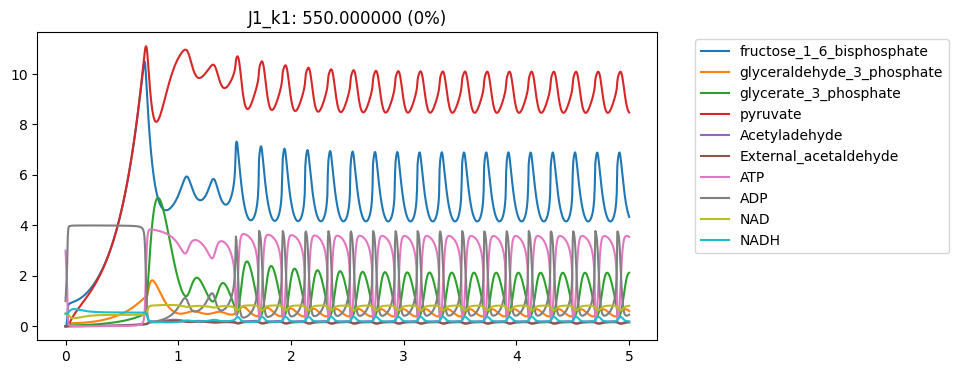

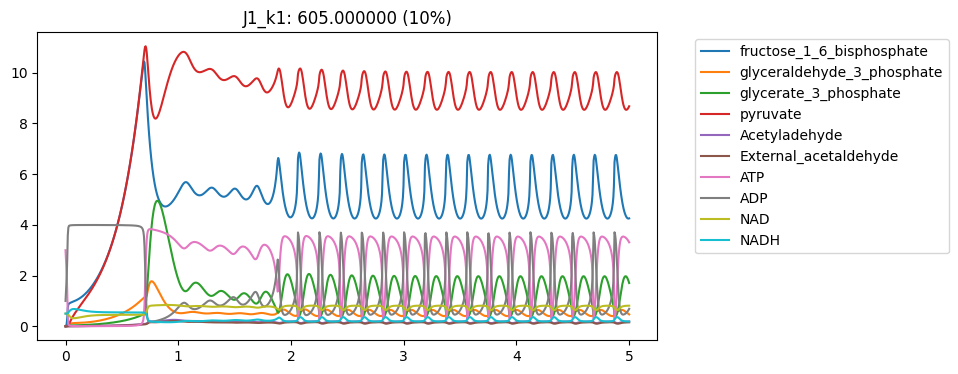

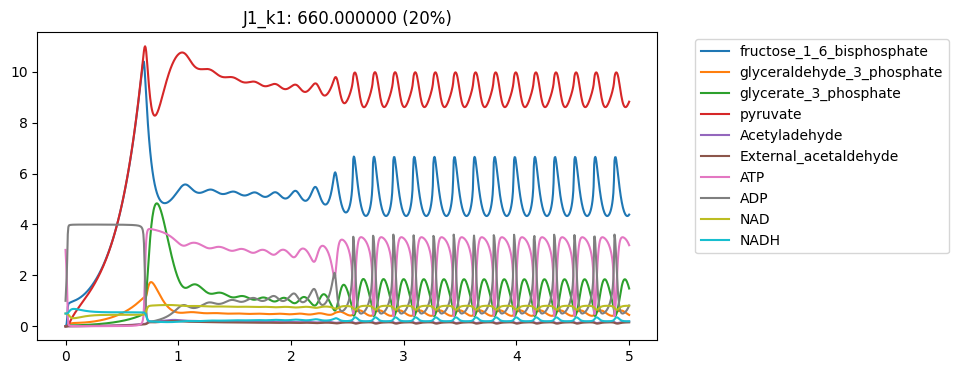

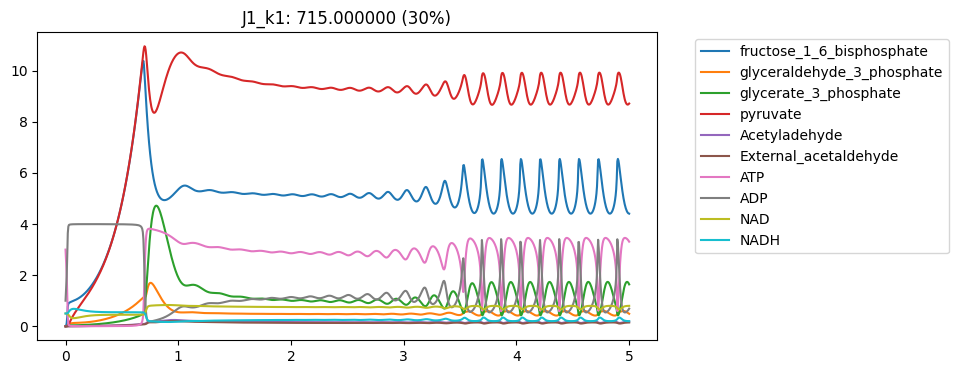

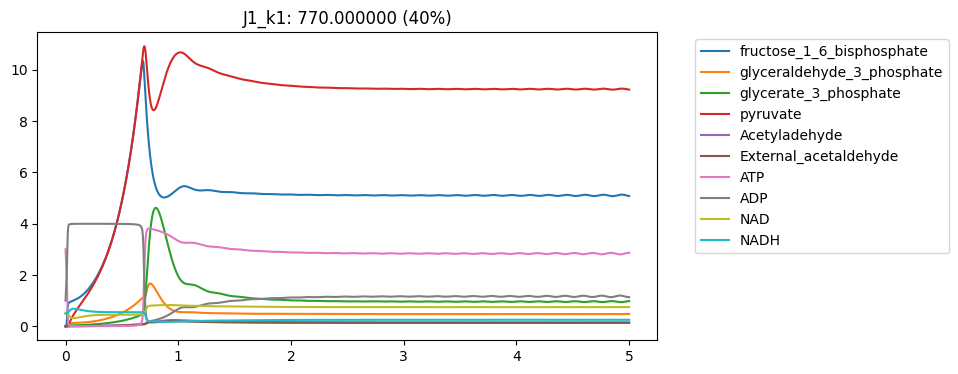

In [19]:
# Experiments
changes = 10*np.array(range(5))
length = len(changes)
_ = runSimulations(FACTOR, changes)

In [20]:
df_dct = runSimulations("J1_k1", [10, 20], model=WOLF_MODEL, isPlot=False)
#_ = runSimulations("J5_k", [10, 20], model=WOLF_MODEL, isPlot=True)

In [21]:
df_dct[10].head()

,Glucose,fructose_1_6_bisphosphate,glyceraldehyde_3_phosphate,glycerate_3_phosphate,pyruvate,Acetyladehyde,External_acetaldehyde,ATP,ADP,NAD,NADH
time,,,,,,,,,,,
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,3.000000,1.000000,0.500000,0.500000
0.005005,0.232439,0.017541,0.000447,0.000063,0.000007,2.722865e-08,5.840183e-09,2.573672,1.426328,0.499954,0.500046
0.010010,0.404882,0.092974,0.003714,0.000922,0.000260,1.391642e-06,4.825776e-07,2.091369,1.908631,0.499206,0.500794
0.015015,0.428088,0.311057,0.014362,0.004314,0.002347,1.413709e-05,6.077154e-06,1.396165,2.603835,0.495454,0.504546
0.020020,0.233489,0.729774,0.041968,0.012760,0.012402,7.883218e-05,3.805547e-05,0.413850,3.586150,0.482702,0.517298


In [22]:
df_dct.keys()

dict_keys([10, 20])

In [23]:
df_dct[10]["Glucose"]

time
0.000000    0.000000
0.005005    0.232439
0.010010    0.404882
0.015015    0.428088
0.020020    0.233489
              ...   
4.979980    2.489290
4.984985    2.552080
4.989990    2.605641
4.994995    2.649587
5.000000    2.683375
Name: Glucose, Length: 1000, dtype: float64

**Questions**
1. What happens when K_I is increased?
1. Do other factors behave in a similar way in that the onset of cyclic behavior is delayed with a larger change?
1. What metric(s) should we use to quantify the effect on cyclic behavior?

# Calculating Responses

For the Wolf model, our response is *not* a collection of simulation time series.
Instead, it is the oscillation frequency detected in the time series for a particular molecule.

## Fast Fourier Transform (FFT)


How do we transform the output of the simulation into the desired response?

The most common way to characterize oscillations in a time series is the Fast Fourier Transform (FFT).
The FFT provides a two arrays. The first is a list of frequencies. The second is a coefficient whose magnitude indicates the
contribution of that frequency to the time series.
We are looking for the frequency that has the largest contribution, assuming that it's magnitude exceeds a minimum value.

In [24]:
def calculateFft(molecule, df, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.

    Arguments
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: species
    offset: int
        Initial data that are not included in the FFT calculation

    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    times = np.array(df.index)
    values = df[molecule].values
    numPoint = len(times)
    count = numPoint - offset
    endTime = times[-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft(SPECIES, WOLF_DF)
assert(max(fftValues) > 90)  # Top frequency should have a large magnitude
print("OK!")

OK!


In [25]:
calculateFft("Glucose", df_dct[10], offset=100)

(array([   0.22222222,    0.44444444,    0.66666667,    0.88888889,
           1.11111111,    1.33333333,    1.55555556,    1.77777778,
           2.        ,    2.22222222,    2.44444444,    2.66666667,
           2.88888889,    3.11111111,    3.33333333,    3.55555556,
           3.77777778,    4.        ,    4.22222222,    4.44444444,
           4.66666667,    4.88888889,    5.11111111,    5.33333333,
           5.55555556,    5.77777778,    6.        ,    6.22222222,
           6.44444444,    6.66666667,    6.88888889,    7.11111111,
           7.33333333,    7.55555556,    7.77777778,    8.        ,
           8.22222222,    8.44444444,    8.66666667,    8.88888889,
           9.11111111,    9.33333333,    9.55555556,    9.77777778,
          10.        ,   10.22222222,   10.44444444,   10.66666667,
          10.88888889,   11.11111111,   11.33333333,   11.55555556,
          11.77777778,   12.        ,   12.22222222,   12.44444444,
          12.66666667,   12.88888889,   13.11111

Which frequencies are the largest?

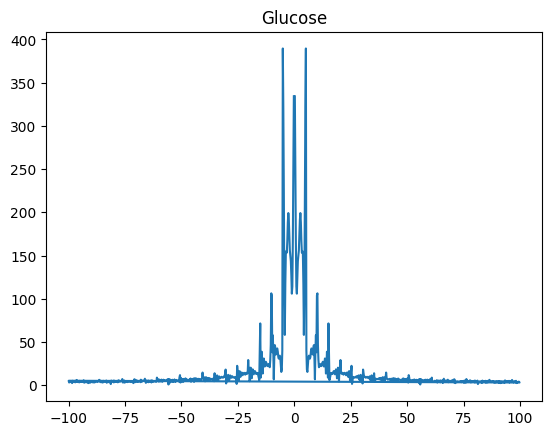

In [26]:
def plotFft(molecule, df=WOLF_DF, ax=None, isPlot=True, **kwargs):
    """
    Plot the FFT for a molecule.

    Arguments
    ----------
    df: DataFrame
        index: time
        columns: floating species
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, df=df, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    if isPlot:
        plt.show()

# Tests
plotFft(SPECIES, isPlot=False)  # "Smoke" test

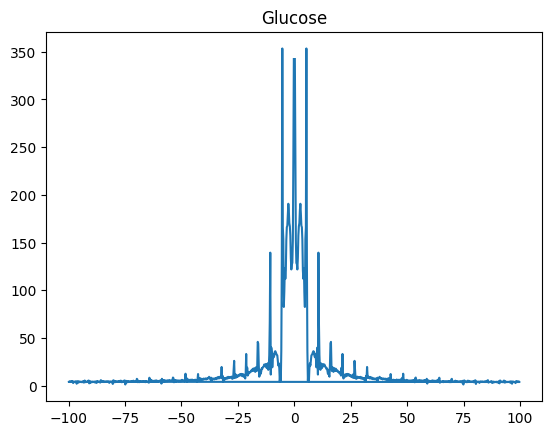

In [27]:
plotFft("Glucose", df=df_dct[10], offset=100)

## Calculate peak frequency

The response we'll use is the frequency with the largest peak.
We want to calculate this frequency for the chemical species.

In [28]:
def calculatePeakFrequency(molecule, dataDF, numDelete=0, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.

    Arguments
    ----------
    molecule: str
    dataDF: DataFrame
    offset: int
        Initial data that are not included in the FFT calculation

    Returns
    -------
    float: peak frequency
    float: amplitude
    """
    def getIndexOfMax(arr):
        maxx = max(arr)
        lst = list(arr)
        return lst.index(maxx)
    def deleteArrayElement(arr, idx):
        lst = list(arr)
        lst1 = lst[:idx]
        lst2 = lst[idx+1:]
        newLst = lst1.extend(lst2)
        return np.array(lst1)
    #
    frequencies, amplitudes = calculateFft(molecule, dataDF)
    # Delete the largest N values
    for _ in range(numDelete):
        maxIdx = getIndexOfMax(amplitudes)
        frequencies = deleteArrayElement(frequencies, maxIdx)
        amplitudes = deleteArrayElement(amplitudes, maxIdx)
    # Report the next highest value
    maxIdx = getIndexOfMax(amplitudes)
    return frequencies[maxIdx], amplitudes[maxIdx]

# TESTS
peak_frequency, peak_amplitude = calculatePeakFrequency(SPECIES, WOLF_DF)
assert(peak_frequency > 0)
assert(peak_amplitude > 0)
print("OK!")

OK!


In [29]:
calculatePeakFrequency("Glucose", df_dct[10])

(5.333333333333333, 353.46612265440007)

## Run simulations and calculate responses

In [30]:
WOLF_FACTORS

['J0_inputFlux',
 'J1_k1',
 'J1_Ki',
 'J1_n',
 'J2_k',
 'J3_k',
 'J4_kg',
 'J4_kp',
 'J4_ka',
 'J4_kk',
 'J5_k',
 'J6_k',
 'J7_k',
 'J8_k1',
 'J8_k2',
 'J9_k',
 'J10_k']

In [31]:
def calculateFrequencyResponses(factors=WOLF_FACTORS, percents=[0], molecule=SPECIES):
    """
    Calculates the amplitude at the peak frequency for a 1WD for the factors and
    levels expressed as percents.

    Parameters
    ----------
    factors: list-str (kinetic constants)
    percents: float (peak frequency for the changes indicated)

    Returns
    -------
    pd.DataFrame
       rows: factor
       columns: percents
       values: amplitudes
    """
    percent_dct = {p: [] for p in percents}
    for factor in factors:
        data_dct = runSimulations(factor, percents, isPlot=False)
        # Calculate the FFT for all percents for this factor
        for percent in data_dct.keys():
            _, amplitude = calculatePeakFrequency(molecule, data_dct[percent])
            percent_dct[percent].append(amplitude)
    return pd.DataFrame(percent_dct, index=factors)

df = calculateFrequencyResponses(percents=[-2, 0, 2])
assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


In [32]:
PERCENTS = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
columns = list(WOLF_DF.columns)
RESPONSE_DF = calculateFrequencyResponses(percents=PERCENTS)
RESPONSE_DF

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,205.184051,307.945849,370.046484,384.288492,389.487765,376.881555,415.678629,347.799893,370.943942
J1_k1,447.483594,426.492449,400.491421,399.908813,389.487765,384.005328,342.031859,353.466123,331.838105
J1_Ki,914.781730,625.034533,561.465991,421.006728,389.487765,377.152702,339.014955,297.709664,274.870401
J1_n,259.597349,289.306737,304.192375,348.059980,389.487765,422.672741,546.505075,659.935087,1256.216535
J2_k,829.566382,531.256436,439.815269,395.220732,389.487765,368.216851,387.221047,462.812105,486.412475
J3_k,361.262100,426.522032,369.507028,383.010422,389.487765,394.132570,398.368532,396.465501,350.293397
J4_kg,396.595424,415.803018,406.091888,396.665943,389.487765,381.818246,369.959397,397.237306,472.777582
J4_kp,398.880612,395.397374,392.624466,390.782400,389.487765,388.097888,385.991366,382.266892,374.030314
J4_ka,374.069721,381.411754,385.825128,388.065429,389.487765,390.745901,392.491029,394.912032,398.156090
J4_kk,381.226947,386.030161,387.903669,388.923802,389.487765,389.966078,390.755884,391.732801,392.977109


**Questions**
1. Which factors show an effect on frequency for the levels considered?
1. Of these, which factor values are inversely related to frequency?

# Calculating DOE Parameters

For a 1WD, the DOE parameters are $\mu$ and $\alpha_{i, k_i}$.
These parameters are calculated for each response.
In the Wolf model, a response is the peak frequencies of a chemical species.
Recall that:
* $\mu$ is the baseline for the simulation.
* $\alpha_{i, k_i} = y_{i, k_i} - \mu$

In [33]:
def calculate1WDParameters(response_df):
    """
    Calculates the design of experiment parameters for a 1-Way Design.
    Assumes that there is a level of 0.

    Args:
    -----
    responseDF: pd.DataFrame
        column: levels
        index: factors
        values: y_i,k_i

    Returns:
    --------
    float: Mu
    pd.DataFrame
        columns: levels (k_i)
        index: factors (i)
        values: \alpha_i,k_i
    """
    factors = list(response_df.index)
    factor = factors[0]
    mu = response_df.loc[factor, 0]
    result_df = response_df - mu
    return mu, result_df

# TESTS
mu, response_df = calculate1WDParameters(RESPONSE_DF)
assert(isinstance(response_df, pd.DataFrame))
print("OK!")

OK!


In [34]:
mu, response_df = calculate1WDParameters(RESPONSE_DF)
print(mu)
response_df

389.48776510684354


,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,-184.303714,-81.541916,-19.441281,-5.199273,0.0,-12.606210,26.190864,-41.687872,-18.543823
J1_k1,57.995829,37.004684,11.003656,10.421048,0.0,-5.482437,-47.455906,-36.021642,-57.649660
J1_Ki,525.293965,235.546768,171.978226,31.518963,0.0,-12.335063,-50.472810,-91.778101,-114.617364
J1_n,-129.890416,-100.181028,-85.295390,-41.427785,0.0,33.184976,157.017310,270.447322,866.728770
J2_k,440.078617,141.768671,50.327504,5.732967,0.0,-21.270914,-2.266718,73.324340,96.924710
J3_k,-28.225665,37.034267,-19.980737,-6.477344,0.0,4.644805,8.880767,6.977736,-39.194369
J4_kg,7.107659,26.315253,16.604123,7.178178,0.0,-7.669519,-19.528368,7.749541,83.289817
J4_kp,9.392847,5.909609,3.136701,1.294635,0.0,-1.389877,-3.496399,-7.220873,-15.457451
J4_ka,-15.418044,-8.076012,-3.662637,-1.422336,0.0,1.258136,3.003264,5.424267,8.668325
J4_kk,-8.260818,-3.457604,-1.584096,-0.563963,0.0,0.478313,1.268119,2.245035,3.489344


**Questions**
1. In many cases $\alpha_{i,k_i}$ is 0. What does this mean?

# Running a Study

A study is a collection of experiments in which one or more factors are set to different levels.
For a 1WD, only one factor at a time is changed.

In [35]:
def runStudy(factors=WOLF_FACTORS, percents=[0], molecule=SPECIES):
    """
    Runs a 1WD for the factors and levels expressed as percents.

    Args:
    ----------
    factors: list-str (kinetic constants)
    percents: float

    Returns
    -------
    float: mu
    pd.DataFrame: alpha_i, k_i
       rows: factor
       columns: percents
       values: frequency
    """
    df = calculateFrequencyResponses(factors=factors, percents=percents,
                                     molecule=molecule)
    return calculate1WDParameters(df)

mu, df = runStudy(percents=[-2, 0, 2])
assert(isinstance(df, pd.DataFrame))
assert(isinstance(mu, float))
print("OK!")

OK!


In [36]:
runStudy(factors=["J1_k1", "J5_k"], percents=[-5, 0, 5], molecule="Glucose")

(389.48776510684354,
               -5    0          5
 J1_k1  11.003656  0.0 -47.455906
 J5_k  -11.044425  0.0   2.916169)

In [37]:
def runVisualStudy(factors, percents, molecule):
    """
    Draw a heatmap of the one way effects (alphas)
    """

Below we calculate the effect of parameter changes on SPECIES.

In [38]:
mu, df = runStudy(percents=[-20, -10, -5, -2, 0, 2, 5, 10, 20], molecule=SPECIES)
df

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,-184.303714,-81.541916,-19.441281,-5.199273,0.0,-12.606210,26.190864,-41.687872,-18.543823
J1_k1,57.995829,37.004684,11.003656,10.421048,0.0,-5.482437,-47.455906,-36.021642,-57.649660
J1_Ki,525.293965,235.546768,171.978226,31.518963,0.0,-12.335063,-50.472810,-91.778101,-114.617364
J1_n,-129.890416,-100.181028,-85.295390,-41.427785,0.0,33.184976,157.017310,270.447322,866.728770
J2_k,440.078617,141.768671,50.327504,5.732967,0.0,-21.270914,-2.266718,73.324340,96.924710
J3_k,-28.225665,37.034267,-19.980737,-6.477344,0.0,4.644805,8.880767,6.977736,-39.194369
J4_kg,7.107659,26.315253,16.604123,7.178178,0.0,-7.669519,-19.528368,7.749541,83.289817
J4_kp,9.392847,5.909609,3.136701,1.294635,0.0,-1.389877,-3.496399,-7.220873,-15.457451
J4_ka,-15.418044,-8.076012,-3.662637,-1.422336,0.0,1.258136,3.003264,5.424267,8.668325
J4_kk,-8.260818,-3.457604,-1.584096,-0.563963,0.0,0.478313,1.268119,2.245035,3.489344


# Visualizing the Results

Even for a model of modest size, the number of DOE $\alpha$ parameters is overwhelming.
Analyzing these parameters is greatly facilitated by using appropriate visualizations.
For tabular data, a heatmap is a natural visualization.

## Example of a heatmap in python

The example below generates a heatmap from a pandas DataFrame.
The horizontal axis are the column names; the vertical axis are the values of the index of the DataFrame.
Values are encoded as a heat representation from 0 to 1.0.

In [39]:
# DataFrame
df = pd.DataFrame({"a": np.random.random(5), "b": np.random.random(5)})
df.index = [10*v for v in range(len(df))]
df

,a,b
0,0.712990,0.262781
10,0.104672,0.999705
20,0.605356,0.102731
30,0.239093,0.772695
40,0.731190,0.344402


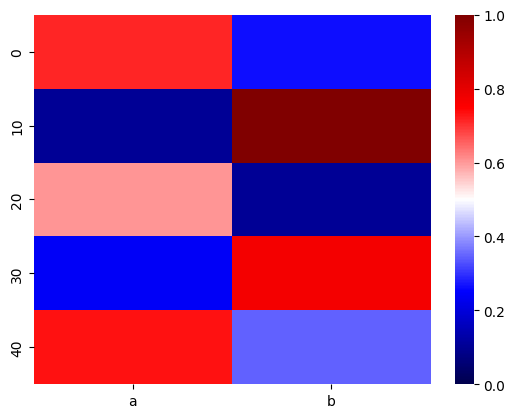

In [40]:
# Generating the heatmap
_ = sns.heatmap(df, cmap='seismic', vmin=0, vmax=1)

## Heatmap for 1WD

In [41]:
mu, df = runStudy(factors=["J1_k1", "J5_k"], percents=[ -5, 0, 5], molecule="Glucose")

In [42]:
mu

389.48776510684354

In [43]:
df

,-5,0,5
J1_k1,11.003656,0.0,-47.455906
J5_k,-11.044425,0.0,2.916169


<Axes: >

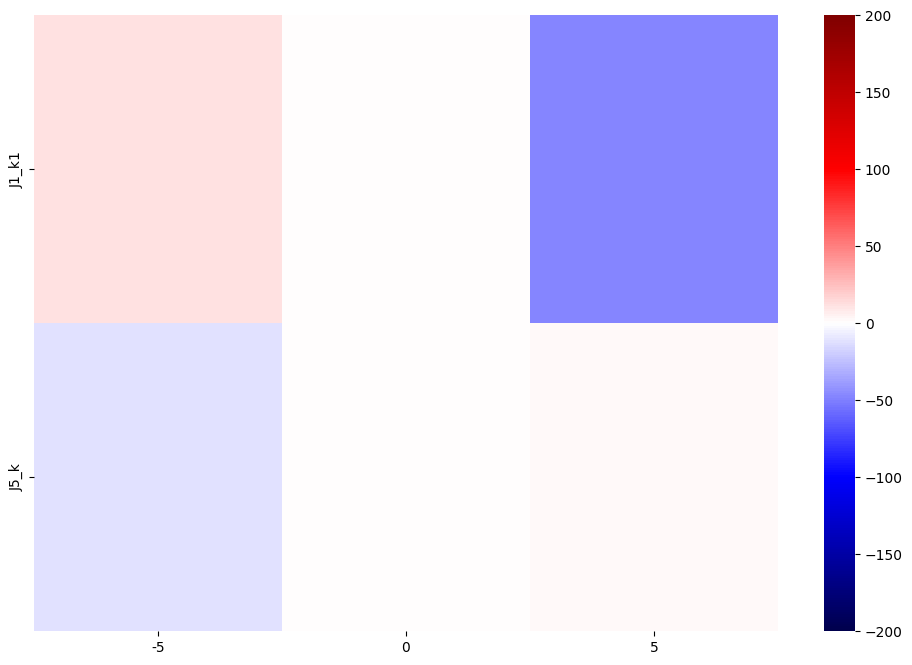

In [44]:
_, ax = plt.subplots(1, figsize=(12, 8))
sns.heatmap(df, cmap="seismic", ax=ax, vmin=-200, vmax=200)

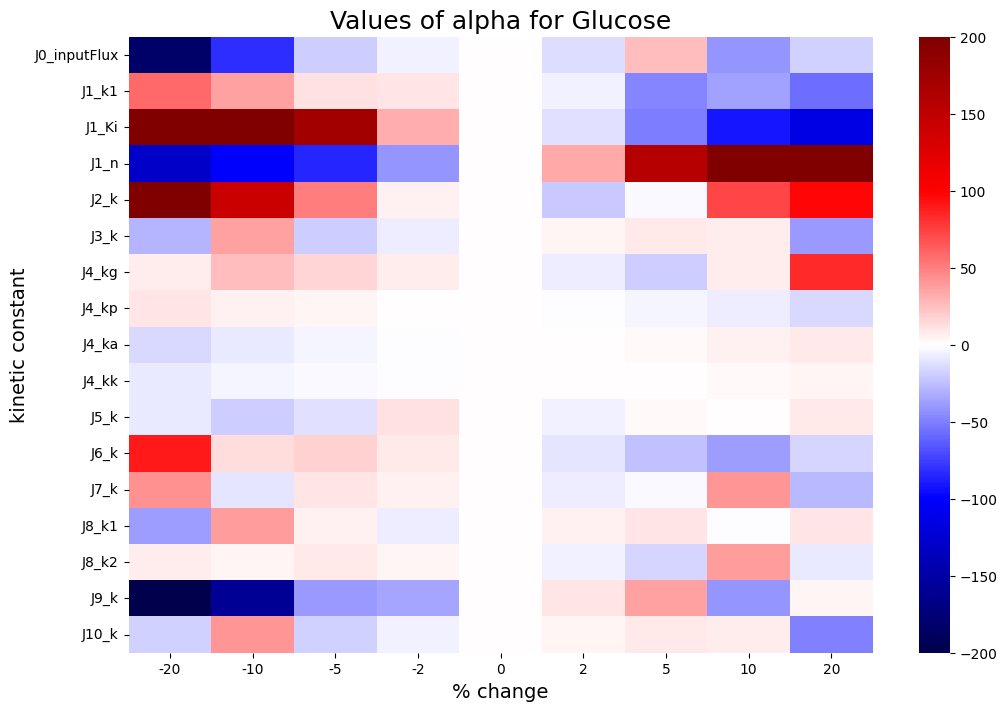

In [45]:
# Visualization for NADH
mu, df = runStudy(percents=[-20, -10, -5, -2, 0, 2, 5, 10, 20], molecule=SPECIES)
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.heatmap(df, cmap="seismic", ax=ax, vmin=-200, vmax=200)
plt.ylabel("kinetic constant", fontsize=14)
plt.xlabel("% change", fontsize=14)
_ = plt.title("Values of alpha for %s" % SPECIES, fontsize=18)

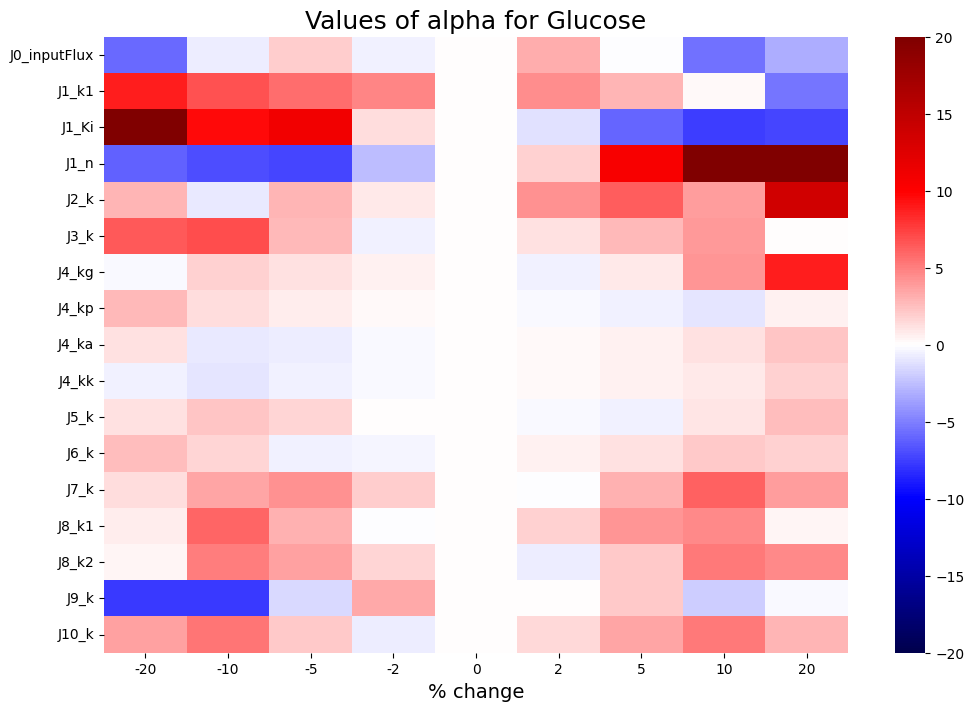

In [46]:
# Visualization for NADH
mu, df = runStudy(percents=[-20, -10, -5, -2, 0, 2, 5, 10, 20], molecule="NADH")
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.heatmap(df, cmap="seismic", ax=ax, vmin=-20, vmax=20)
plt.xlabel("% change", fontsize=14)
_ = plt.title("Values of alpha for %s" % SPECIES, fontsize=18)

# Study J9_k in more detail

In [47]:
WOLF_FACTORS

['J0_inputFlux',
 'J1_k1',
 'J1_Ki',
 'J1_n',
 'J2_k',
 'J3_k',
 'J4_kg',
 'J4_kp',
 'J4_ka',
 'J4_kk',
 'J5_k',
 'J6_k',
 'J7_k',
 'J8_k1',
 'J8_k2',
 'J9_k',
 'J10_k']

In [48]:
_, df = runStudy(factors=["J1_k1", "J9_k"], percents=[n-20 for n in range(80)], molecule="Glucose")

In [49]:
df

,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,...,50,51,52,53,54,55,56,57,58,59
J1_k1,57.995829,113.803395,153.788425,164.286166,142.463164,93.220777,24.008448,13.068671,26.662438,35.526728,...,-114.025207,-114.718813,-115.412349,-116.100096,-116.782278,-117.458029,-118.134763,-118.803570,-119.468613,-120.127875
J9_k,-249.976824,-247.486471,-244.877484,-241.129519,-228.008495,-215.298656,-203.008329,-191.172493,-179.795381,-168.889481,...,97.131302,98.731491,101.326557,105.179150,106.613366,109.870830,112.572259,114.964294,117.741289,120.268874


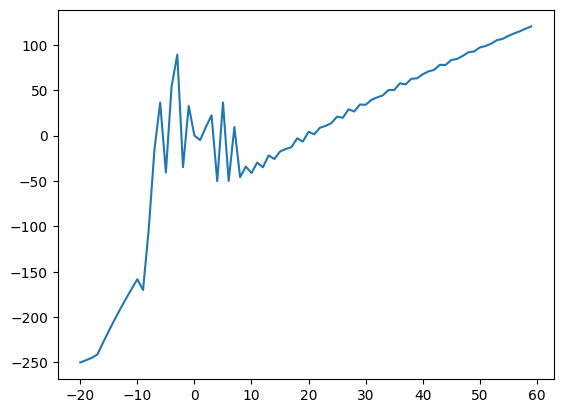

In [50]:
plt.plot(df.columns, df.loc["J9_k", :])

# Exercise

Compare the effect of parameters on Glucose with their effects on NADH. Which parameters have more of an effect on Glucose than on NADH?
* Hint: Manipulate the dataframes returned from ``runStudy``

## Answer

In [51]:
PERCENTS = [-20, -10, -5, -2, 0, 2, 5, 10, 20]
_, df1 = runStudy(percents=PERCENTS, molecule="Glucose")
_, df2 = runStudy(percents=PERCENTS, molecule="NADH")

In [52]:
# Effects
df1 - df2

,-20,-10,-5,-2,0,2,5,10,20
J0_inputFlux,-178.418063,-80.889120,-21.340115,-4.613501,0.0,-15.837912,26.202180,-36.100183,-15.314408
J1_k1,49.236410,30.207704,5.316700,5.722518,0.0,-9.870718,-50.375164,-36.254349,-52.243833
J1_Ki,501.774135,226.012440,161.031336,30.249787,0.0,-11.151850,-44.388874,-84.262089,-107.379963
J1_n,-123.750336,-93.217540,-78.011035,-38.820674,0.0,31.393326,146.448103,249.609157,836.289616
J2_k,437.185843,142.582373,47.414548,4.805026,0.0,-25.516142,-8.551119,69.540981,83.277689
J3_k,-34.688034,30.037263,-22.791573,-5.954949,0.0,3.445317,6.173278,3.059526,-39.291638
J4_kg,7.381661,24.568781,15.429368,6.656408,0.0,-7.099970,-20.420937,3.618108,74.529779
J4_kp,6.653619,4.584855,2.490275,1.040210,0.0,-1.140722,-2.885766,-6.141328,-15.973971
J4_ka,-16.613430,-7.191779,-3.021280,-1.168378,0.0,1.009549,2.388098,4.224026,6.403457
J4_kk,-7.696650,-2.490424,-1.103201,-0.371489,0.0,0.288888,0.796077,1.310062,1.665197
